# Практика застосування PCA. EDA датасету Breast Cancer Wisconsin

### Знайомство з даними

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
data, target = load_breast_cancer(return_X_y=True, as_frame=True)
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### Розподіл цільової змінної і правило 1:10

In [4]:
target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

# Практика застосування PCA. Підготовка й обробка даних

### Очистка від викидів

In [5]:
out = (data
       .apply(lambda x:
              np.abs(zscore(x))
              .ge(3))
       .astype(int)
       .mean(1))

out_ind = np.where(out > 0.2)[0]

data.drop(out_ind, inplace=True)
target.drop(out_ind, inplace=True)

In [6]:
data.shape

(562, 30)

### Розбиття на тренувальну і тестову вибірки

In [7]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        data,
        target,
        test_size=0.2,
        random_state=42))

### Нормалізація змінних

In [8]:
scaler = StandardScaler().set_output(transform='pandas')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Зменшення розмірності даних

In [9]:
pca = PCA().set_output(transform='pandas').fit(X_train)

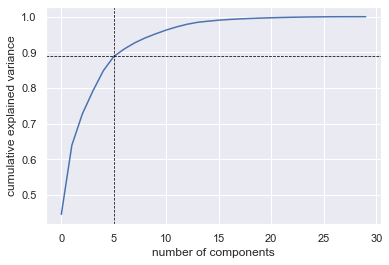

In [10]:
sns.set_theme()

explained_variance = np.cumsum(pca.explained_variance_ratio_)

ax = sns.lineplot(explained_variance)
ax.set(xlabel='number of components',
       ylabel='cumulative explained variance')

n_components = np.searchsorted(explained_variance, 0.85)

ax.axvline(x=n_components,
           c='black',
           linestyle='--',
           linewidth=0.75)

ax.axhline(y=explained_variance[n_components],
           c='black',
           linestyle='--',
           linewidth=0.75)

In [11]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
X_train_pca.iloc[:, :n_components].head()

,pca0,pca1,pca2,pca3,pca4
471,-1.929969,-0.850474,3.491870,2.458801,-0.462936
0,10.076273,1.756517,-0.945022,-3.233516,-2.160090
12,8.868784,2.689110,6.603851,-0.357798,1.227696
454,-2.778858,-1.078334,-1.625110,-0.261071,0.184463
23,4.792710,-5.567007,-0.079847,0.719455,-0.709729


### Візуалізація вхідного набору даних

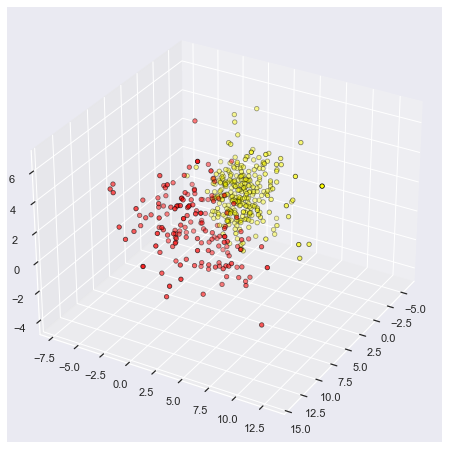

In [13]:
plt.figure(figsize=(8, 8))

ax = plt.subplot(projection='3d')

ax.scatter3D(
    X_train_pca.iloc[:, 0],
    X_train_pca.iloc[:, 1],
    X_train_pca.iloc[:, 2],
    c=y_train,
    s=20,
    cmap='autumn',
    ec='black',
    lw=0.75)

ax.view_init(elev=30, azim=30)

# Практика застосування PCA. Побудова й оцінка моделі

In [14]:
clf_full = GradientBoostingClassifier()

clf_full.fit(X_train, y_train)

pred_full = clf_full.predict(X_test)

score_full = accuracy_score(y_test, pred_full)

print(f'Model accuracy: {score_full:.1%}')

Model accuracy: 93.8%


In [15]:
clf_pca = GradientBoostingClassifier()

clf_pca.fit(X_train_pca.iloc[:, :n_components], y_train)

pred_pca = clf_pca.predict(X_test_pca.iloc[:, :n_components])

score_pca = accuracy_score(y_test, pred_pca)

print(f'Model accuracy (PCA): {score_pca:.1%}')

Model accuracy (PCA): 96.5%


### Важливі ознаки й головні компоненти

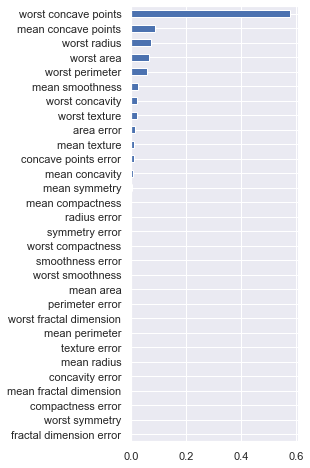

In [16]:
plt.figure(figsize=(3, 8))

(pd.Series(
    data=clf_full.feature_importances_,
    index=X_train.columns)
    .sort_values(ascending=True)
    .plot
    .barh())